In [ ]:
### https://github.com/hosseinshn/Basic-Multi-task-Learning/blob/master/MTL-Pytorch.ipynb

In [36]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import random
import math


### Prepare the data

In [3]:
seed = 42
random.seed(seed)
torch.cuda.manual_seed_all(seed)

N = 10000
M = 100
c = 0.5
p = 0.9
k = np.random.randn(M)
u1 = np.random.randn(M)
u1 -= u1.dot(k) * k / np.linalg.norm(k)**2
u1 /= np.linalg.norm(u1)
k /= np.linalg.norm(k)
u2 = k
w1 = c*u1
w2 = c*(p*u1+np.sqrt((1-p**2))*u2)
X = np.random.normal(0, 1, (N, M))
eps1 = np.random.normal(0, 0.01)
eps2 = np.random.normal(0, 0.01)
Y1 = np.matmul(X, w1) + np.sin(np.matmul(X, w1))+eps1
Y2 = np.matmul(X, w2) + np.sin(np.matmul(X, w2))+eps2
split = list(np.random.permutation(N))

In [10]:
X_train = X[split[0:8000],:]
Y1_train = Y1[split[0:8000]]
Y2_train = Y2[split[0:8000]]
X_valid = X[8000:9000,:]
Y1_valid = Y1[8000:9000]
Y2_valid = Y2[8000:9000]
X_test = X[9000:10000,:]
Y1_test = Y1[9000:10000]
Y2_test = Y2[9000:10000]
print("X_train shape:",X_train.shape)
print("X_valid shape:",X_valid.shape)
print("X_test shape:",X_test.shape)
print("Y1_train shape:",Y1_train.shape)
print("Y2_train shape:",Y2_train.shape)
print("Y1_valid shape:",Y1_valid.shape)
print("Y2_valid shape:",Y2_valid.shape)
print("Y1_test shape:",Y1_test.shape)
print("Y2_test shape:",Y2_test.shape)

X_train shape: (8000, 100)
X_valid shape: (1000, 100)
X_test shape: (1000, 100)
Y1_train shape: (8000,)
Y2_train shape: (8000,)
Y1_valid shape: (1000,)
Y2_valid shape: (1000,)
Y1_test shape: (1000,)
Y2_test shape: (1000,)


### MTL definition

In [18]:
print("X shape:", X.shape)
input_size = X.shape[0]
feature_size = X.shape[1]
print("Input size [row]:", input_size)
print("Feature size [cols]:", feature_size)

shared_layer_size = 64
layer_1_h_size = 32
layer_2_h_size = 16
output_size = 1

lr = 0.001
epoch = 50
batch_size = 100

cost_task_1 = []
cost_task_2 = []

cost_task_val_1 = []
cost_task_val_2 = []

cost_task_test_1 = []
cost_task_test_2 = []

cost_total = []
cost_validation = []
cost_test = []

X shape: (10000, 100)
Input size [row]: 10000
Feature size [cols]: 100


In [19]:
class MTLnet(nn.Module):
    def __init__(self):
        super(MTLnet, self).__init__()

        self.shared_layer = nn.Sequential(
            nn.Linear(feature_size, shared_layer_size),
            nn.ReLU(),
            nn.Dropout()
        )

        self.task1_layer = nn.Sequential(
            nn.Linear(shared_layer_size, layer_1_h_size),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(layer_1_h_size, layer_2_h_size),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(layer_2_h_size, output_size)
        )

        self.task2_layer = nn.Sequential(
            nn.Linear(shared_layer_size, layer_1_h_size),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(layer_1_h_size, layer_2_h_size),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(layer_2_h_size, output_size)
        )

    def forward(self, x):
        h_shared = self.shared_layer(x)
        out1 = self.task1_layer(h_shared)
        out2 = self.task2_layer(h_shared)

        return out1, out2

### Create a function to retrieve mini batches

In [24]:
def random_mini_batches(XE, R1E, R2E, mini_batch_size = 10, seed = 42):
    # Creating the mini-batches
    np.random.seed(seed)
    m = XE.shape[0]
    mini_batches = []
    permutation = list(np.random.permutation(m))
    shuffled_XE = XE[permutation,:]
    shuffled_X1R = R1E[permutation]
    shuffled_X2R = R2E[permutation]
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, int(num_complete_minibatches)):
        mini_batch_XE = shuffled_XE[k * mini_batch_size : (k+1) * mini_batch_size, :]
        mini_batch_X1R = shuffled_X1R[k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch_X2R = shuffled_X2R[k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch = (mini_batch_XE, mini_batch_X1R, mini_batch_X2R)
        mini_batches.append(mini_batch)
    Lower = int(num_complete_minibatches * mini_batch_size)
    Upper = int(m - (mini_batch_size * math.floor(m/mini_batch_size)))
    if m % mini_batch_size != 0:
        mini_batch_XE = shuffled_XE[Lower : Lower + Upper, :]
        mini_batch_X1R = shuffled_X1R[Lower : Lower + Upper]
        mini_batch_X2R = shuffled_X2R[Lower : Lower + Upper]
        mini_batch = (mini_batch_XE, mini_batch_X1R, mini_batch_X2R)
        mini_batches.append(mini_batch)

    return mini_batches


### Define a Loss Function

In [109]:
def MTL_Loss(Yhat1, YE1, Yhat2, YE2):
    lf = nn.MSELoss()
    l1 = lf(Yhat1, YE1.view(-1,1))
    l2 = lf(Yhat2, YE2.view(-1,1))
    loss = (l1 + l2) / 2

    return loss

### Compile the network

In [116]:
MTL = MTLnet()
optimizer = torch.optim.Adam(MTL.parameters(), lr=lr)
loss_func = nn.MSELoss()



### Train the network

In [117]:
for iteration in range(epoch):
    epoch_cost = 0
    epoch_cost_task1 = 0
    epoch_cost_task2 = 0

    num_minibatches = int(input_size/batch_size)
    print("Num minibatches",num_minibatches)
    minibatches = random_mini_batches(X_train, Y1_train, Y2_train, batch_size)
    print("Minibatch size", len(minibatches))

    for minibatch in minibatches:
        XE, YE1, YE2 = minibatch

        XE = torch.from_numpy(XE).float()
        YE1 = torch.from_numpy(YE1).float()
        YE2 = torch.from_numpy(YE2).float()
        Yhat1, Yhat2 = MTL(XE)


        l1 = loss_func(Yhat1, YE1.view(-1,1))
        l2 = loss_func(Yhat2, YE2.view(-1,1))
        loss = (l1 + l2) / 2

        #loss = MTL_Loss(Yhat1, YE1, Yhat2, YE2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_cost = epoch_cost + (loss/num_minibatches)
        epoch_cost_task1 = epoch_cost_task1 + (l1/num_minibatches)
        epoch_cost_task2 = epoch_cost_task2 + (l2/num_minibatches)

    cost_total.append(torch.mean(epoch_cost))
    cost_task_1.append(torch.mean(epoch_cost_task1))
    cost_task_2.append(torch.mean(epoch_cost_task2))

    with torch.no_grad(): # To evaluate
        #X_valid = torch.from_numpy(X_valid).float()
        #Y1_valid = torch.from_numpy(Y1_valid).float()
        #Y2_valid = torch.from_numpy(Y2_valid).float()

        Y_hat_val_1, Y_hat_val_2 = MTL(X_valid)
        loss_val_1 = loss_func(Y_hat_val_1, Y1_valid.view(-1,1))
        loss_val_2 = loss_func(Y_hat_val_2, Y2_valid.view(-1,1))
        loss_val = (loss_val_1+loss_val_2)/2

        cost_task_val_1.append(loss_val_1)
        cost_task_val_2.append(loss_val_2)
        cost_validation.append(loss_val)
        print("Iter-{}, Total Loss: {:.4}".format(iteration+1, loss.data.item()))
        print()

Num minibatches 100
Minibatch size 80
Iter-1, Total Loss: 0.5922

Num minibatches 100
Minibatch size 80
Iter-2, Total Loss: 0.3165

Num minibatches 100
Minibatch size 80
Iter-3, Total Loss: 0.2383

Num minibatches 100
Minibatch size 80
Iter-4, Total Loss: 0.1684

Num minibatches 100
Minibatch size 80
Iter-5, Total Loss: 0.1933

Num minibatches 100
Minibatch size 80
Iter-6, Total Loss: 0.1861

Num minibatches 100
Minibatch size 80
Iter-7, Total Loss: 0.1607

Num minibatches 100
Minibatch size 80
Iter-8, Total Loss: 0.1459

Num minibatches 100
Minibatch size 80
Iter-9, Total Loss: 0.1343

Num minibatches 100
Minibatch size 80
Iter-10, Total Loss: 0.1574

Num minibatches 100
Minibatch size 80
Iter-11, Total Loss: 0.1628

Num minibatches 100
Minibatch size 80
Iter-12, Total Loss: 0.1578

Num minibatches 100
Minibatch size 80
Iter-13, Total Loss: 0.1429

Num minibatches 100
Minibatch size 80
Iter-14, Total Loss: 0.1413

Num minibatches 100
Minibatch size 80
Iter-15, Total Loss: 0.1893

Num 

### Plots

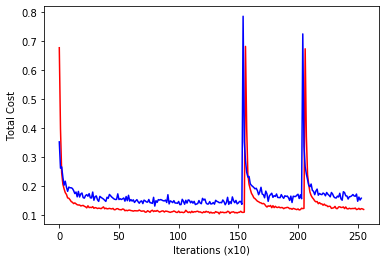

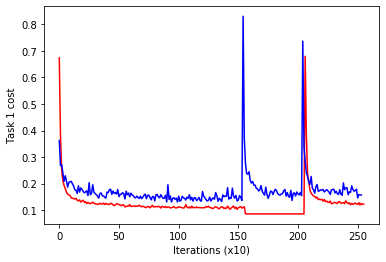

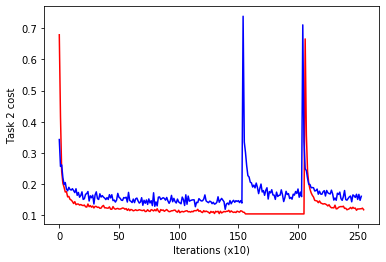

In [118]:
plt.plot(np.squeeze(cost_total), '-r', np.squeeze(cost_validation), '-b')
plt.ylabel('Total Cost')
plt.xlabel("Iterations (x10)")
plt.show()

plt.plot(np.squeeze(cost_task_1), '-r', np.squeeze(cost_task_val_1), '-b')
plt.ylabel("Task 1 cost")
plt.xlabel("Iterations (x10)")
plt.show()

plt.plot(np.squeeze(cost_task_2), '-r', np.squeeze(cost_task_val_2), '-b')
plt.ylabel("Task 2 cost")
plt.xlabel("Iterations (x10)")
plt.show()

### Trying the testing

In [119]:
# Get the first element from test
#X_test_0 = X_test[0]
print("Task 1 ground truth")
print(Y1_test[:10])
print("Task 1 ground truth")
print(Y2_test[:10])


with torch.no_grad(): # To evaluate
    for test in X_test[:10]:
        out1, out2 = MTL(test.float())
        print("{:.4}\t{:.4}".format(out1.item(), out2.item()))


Task 1 ground truth
[-0.72161804  0.74349062  1.61617758 -0.44607916  0.49524973  0.07754001
 -1.70951239 -0.17257475  0.26834699 -1.35984282]
Task 1 ground truth
[-0.67468327  0.90825528  1.50279447  0.23291663  0.09244194  0.45388838
 -1.42987715 -0.30332321  0.39646699 -1.14497807]
-0.988	-0.5633
0.5529	0.4359
0.6248	1.14
-0.1705	0.2934
0.4536	0.2863
0.05325	0.6751
-1.537	-0.6368
-0.0298	-0.413
0.4582	0.372
-1.855	-1.398
